# Add Data Age Features for LSTM

This notebook adds "data age" columns to track how many days have passed since the last actual observation for macroeconomic indicators. This helps LSTM models understand data freshness vs forward-filled staleness.

In [1]:
import pandas as pd
import numpy as np
import os

## Load Feature-Engineered Data

In [2]:
# Load the data with macro features already joined
data_dir = os.path.join("../../02_Data_Processed/03_Feature_Engineered/")

hbea_df = pd.read_parquet(os.path.join(data_dir, "HBEA_daily_with_macro.parquet"))
gdea_df = pd.read_parquet(os.path.join(data_dir, "GDEA_daily_with_macro.parquet"))

print(f"HBEA shape: {hbea_df.shape}")
print(f"GDEA shape: {gdea_df.shape}")
print(f"\nColumns: {list(hbea_df.columns)}")

HBEA shape: (2679, 28)
GDEA shape: (2638, 28)

Columns: ['close', 'vwap', 'volume_tons', 'turnover_cny', 'cum_turnover_cny', 'is_open', 'is_quiet', 'has_trade', 'gap_days', 'post_weekend', 'post_holiday', 'Hubei_ElectricityConsumption_Monthly_ffill_daily_15', 'Hubei_IndustrialAddedValue_RealPrices_AboveScaleIndustry_YoY_ffill_daily_15', 'Hubei_GDP_Cumulative_ffill_daily_15', 'China_Output_CrudeOilProcessing_Monthly_ffill_daily_15', 'FuturesSettle(Cont)_BrentCrude_ffill_daily_1', 'FuturesClose(Cont)_NYMEX_NatGas_ffill_daily_1', 'China_Output_CrudeSteel_Monthly_ffill_daily_15', 'China_ElectricityGeneration_ThermalPower_Monthly_ffill_daily_15', 'China_TotalSocialFinancing_Monthly_ffill_daily_15', 'FuturesSettle(Cont)_EUA_Futures_ffill_daily_1', 'China_CPI_YoY_ffill_daily_15', 'China_TotalElectricityConsumption_Monthly_ffill_daily_15', 'China_Output_RawCoal_Monthly_ffill_daily_15', 'China_GDP_CurrentPrices_Cumulative_ffill_daily_15', 'China_Output_Cement_Monthly_ffill_daily_15', 'China_Man

## Define Data Age Calculation Function

In [3]:
def add_data_age(df, column):
    """
    Calculate data age for a column.
    Age = 0 when value changes (fresh data)
    Age increments for each day the value stays the same (forward-filled)
    
    Args:
        df: DataFrame with the column
        column: Column name to calculate age for
    
    Returns:
        Series with age values
    """
    # Detect when value actually changes (new observation)
    value_changed = df[column].ne(df[column].shift())
    
    # Group by change points and count days within each group
    # This gives us 0 for first day of new value, then 1, 2, 3...
    age = (~value_changed).groupby(value_changed.cumsum()).cumsum()
    
    return age

## Identify Columns for Age Tracking

In [4]:
# Carbon market columns that don't need age tracking (always fresh daily data)
carbon_columns = ['close', 'vwap', 'volume_tons', 'turnover_cny', 
                  'cum_turnover_cny', 'is_open', 'is_quiet', 'has_trade']

# Get macro columns (those with lag suffixes)
def get_macro_columns(df):
    """Identify macro columns by excluding carbon market columns"""
    return [col for col in df.columns if col not in carbon_columns]

hbea_macro_cols = get_macro_columns(hbea_df)
gdea_macro_cols = get_macro_columns(gdea_df)

print(f"HBEA macro columns ({len(hbea_macro_cols)}): {hbea_macro_cols[:5]}...")
print(f"GDEA macro columns ({len(gdea_macro_cols)}): {gdea_macro_cols[:5]}...")

HBEA macro columns (20): ['gap_days', 'post_weekend', 'post_holiday', 'Hubei_ElectricityConsumption_Monthly_ffill_daily_15', 'Hubei_IndustrialAddedValue_RealPrices_AboveScaleIndustry_YoY_ffill_daily_15']...
GDEA macro columns (20): ['gap_days', 'post_weekend', 'post_holiday', 'Guangdong_GDP_Cumulative_ffill_daily_15', 'Guangdong_ElectricityConsumption_Monthly_ffill_daily_15']...


## Add Data Age Columns

In [5]:
def add_age_columns(df, macro_columns):
    """
    Add age columns for all macro indicators in the dataframe.
    
    Args:
        df: Original dataframe
        macro_columns: List of columns to add age for
    
    Returns:
        DataFrame with added age columns
    """
    df_with_age = df.copy()
    
    for col in macro_columns:
        age_col_name = f"{col}_age"
        df_with_age[age_col_name] = add_data_age(df_with_age, col)
        
    return df_with_age

# Process both datasets
print("Adding age columns for HBEA...")
hbea_lstm = add_age_columns(hbea_df, hbea_macro_cols)

print("Adding age columns for GDEA...")
gdea_lstm = add_age_columns(gdea_df, gdea_macro_cols)

print(f"\nHBEA LSTM shape: {hbea_lstm.shape}")
print(f"GDEA LSTM shape: {gdea_lstm.shape}")

Adding age columns for HBEA...
Adding age columns for GDEA...

HBEA LSTM shape: (2679, 48)
GDEA LSTM shape: (2638, 48)


## Verify Age Calculation

In [6]:
# Check a monthly indicator to verify age calculation
sample_col = 'China_CPI_YoY_ffill_daily_15'
if sample_col in hbea_lstm.columns:
    sample_data = hbea_lstm[[sample_col, f'{sample_col}_age']].iloc[100:130]
    
    # Show periods where value changes and age resets
    value_changes = sample_data[sample_col] != sample_data[sample_col].shift()
    
    print("Sample of data age calculation:")
    print("Value changes (True = new observation):")
    print(sample_data[value_changes | value_changes.shift(-1) | value_changes.shift(-2)])
    
    # Verify age patterns
    print("\nAge statistics:")
    print(f"Max age: {hbea_lstm[f'{sample_col}_age'].max()}")
    print(f"Mean age: {hbea_lstm[f'{sample_col}_age'].mean():.2f}")
    print(f"Age resets (value=0): {(hbea_lstm[f'{sample_col}_age'] == 0).sum()}")

Sample of data age calculation:
Value changes (True = new observation):
            China_CPI_YoY_ffill_daily_15  China_CPI_YoY_ffill_daily_15_age
date                                                                      
2014-09-19                        1.9909                                 4
2014-10-13                        1.9909                                15
2014-10-14                        1.9909                                16
2014-10-15                        1.6275                                 0

Age statistics:
Max age: 44
Mean age: 11.10
Age resets (value=0): 145


## Analyze Age Patterns by Indicator Type

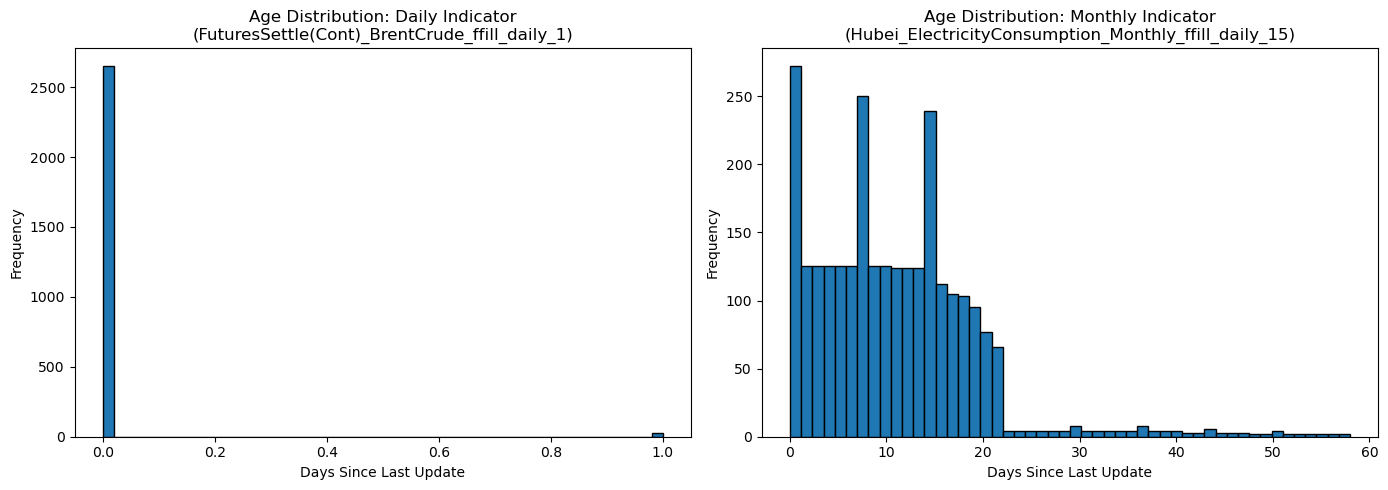

Age Statistics by Indicator Type:
Daily indicator max age: 1 days
Monthly indicator max age: 58 days


In [7]:
# Analyze age patterns for different lag types
import matplotlib.pyplot as plt

# Separate columns by lag type
daily_cols = [col for col in hbea_macro_cols if col.endswith('_1')]
monthly_cols = [col for col in hbea_macro_cols if col.endswith('_15')]

if daily_cols and monthly_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Daily indicator age distribution
    if daily_cols:
        daily_age = hbea_lstm[f'{daily_cols[0]}_age']
        axes[0].hist(daily_age, bins=50, edgecolor='black')
        axes[0].set_title(f'Age Distribution: Daily Indicator\n({daily_cols[0]})')
        axes[0].set_xlabel('Days Since Last Update')
        axes[0].set_ylabel('Frequency')
    
    # Monthly indicator age distribution
    if monthly_cols:
        monthly_age = hbea_lstm[f'{monthly_cols[0]}_age']
        axes[1].hist(monthly_age, bins=50, edgecolor='black')
        axes[1].set_title(f'Age Distribution: Monthly Indicator\n({monthly_cols[0]})')
        axes[1].set_xlabel('Days Since Last Update')
        axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    print("Age Statistics by Indicator Type:")
    print(f"Daily indicator max age: {daily_age.max()} days")
    print(f"Monthly indicator max age: {monthly_age.max()} days")

## Save LSTM-Ready Data

In [8]:
# Save the datasets with age features
output_dir = os.path.join("../../02_Data_Processed/03_Feature_Engineered/")

hbea_output_path = os.path.join(output_dir, "HBEA_LSTM_age_added.parquet")
gdea_output_path = os.path.join(output_dir, "GDEA_LSTM_age_added.parquet")

hbea_lstm.to_parquet(hbea_output_path)
gdea_lstm.to_parquet(gdea_output_path)

print(f"Saved HBEA LSTM data: {hbea_output_path}")
print(f"Shape: {hbea_lstm.shape}")
print(f"\nSaved GDEA LSTM data: {gdea_output_path}")
print(f"Shape: {gdea_lstm.shape}")

Saved HBEA LSTM data: ../../02_Data_Processed/03_Feature_Engineered/HBEA_LSTM_age_added.parquet
Shape: (2679, 48)

Saved GDEA LSTM data: ../../02_Data_Processed/03_Feature_Engineered/GDEA_LSTM_age_added.parquet
Shape: (2638, 48)


## Summary

In [9]:
# Final summary
print("=" * 50)
print("LSTM Data Preparation Complete")
print("=" * 50)
print(f"\nOriginal columns: {len(hbea_df.columns)}")
print(f"Age columns added: {len(hbea_macro_cols)}")
print(f"Total columns: {len(hbea_lstm.columns)}")
print(f"\nColumn structure:")
print(f"- Carbon market: {len(carbon_columns)} columns (no age tracking)")
print(f"- Macro indicators: {len(hbea_macro_cols)} columns (with age tracking)")
print(f"\nExample age column names:")
age_cols = [col for col in hbea_lstm.columns if col.endswith('_age')]
print(age_cols[:5])

LSTM Data Preparation Complete

Original columns: 28
Age columns added: 20
Total columns: 48

Column structure:
- Carbon market: 8 columns (no age tracking)
- Macro indicators: 20 columns (with age tracking)

Example age column names:
['gap_days_age', 'post_weekend_age', 'post_holiday_age', 'Hubei_ElectricityConsumption_Monthly_ffill_daily_15_age', 'Hubei_IndustrialAddedValue_RealPrices_AboveScaleIndustry_YoY_ffill_daily_15_age']
